In [1]:
import geopandas as gpd
import json
import numpy as np
import pandas as pd

# Prepare Data

In [2]:
types=json.load(open('../Data/Table/types.json'))

In [3]:
def simplify_types(types):
    for t in types:
        for attr in ['NAICS', 'LBCS']:
            if attr in types[t]:
                if types[t][attr] is not None:
                    simple_attr={}
                    for floor_section in types[t][attr]:
                        prop=floor_section['proportion']
                        for code in floor_section['use']:
                            if code in simple_attr:
                                simple_attr[code]+=floor_section['use'][code]*prop
                            else:
                                simple_attr[code]=floor_section['use'][code]*prop
                    types[t][attr]=simple_attr
    return types

In [4]:
simple_types=simplify_types(types)

#### Get the ward data

In [5]:
all_zones=gpd.read_file('../outputs/zones.geojson').set_index('GEOID')

#### Get Pandana Road Network

In [6]:
import pandana
import osmnet

In [7]:
bbox=all_zones.total_bounds
nodes_df,edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='walk', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
nodes_df=nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance"]])

/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.35422539,106.35645091,10.75916709,106.69244657);>;);out;'}"
Downloaded 43,874.2KB from www.overpass-api.de in 9.13 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.75751660,106.35645091,11.16049711,106.69473891);>;);out;'}"
Downloaded 54,851.9KB from www.overpass-api.de in 8.18 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestria

# Scenarios

In [8]:
all_lu={i: gpd.read_file('../Data/GIS/Scenario{}/Landuse_scenario_{}/LandUse_{}.shp'.format(i,i,i)) for i in [0,2,3]}

Change s to run the analysis for the different scenarios

In [186]:
s=3

In [187]:
lu=all_lu[s]

In [188]:
lu.head()

,OBJECTID,TypeCode,LandUseTyp,Storey,Height,BCR,FAR,CSLLandTyp,Shape_Leng,Shape_Area,geometry
0,1,CCDT,Administrative,43.0,150.0,77.0,33.10,"Administrative, Public facility",248.427786,3641.900086,"POLYGON Z ((686484.155 1191180.248 0.000, 6864..."
1,2,NNO,Existing Residential,5.0,17.5,89.0,4.45,Residential,592.135801,5716.388408,"POLYGON Z ((686196.515 1191192.126 0.000, 6861..."
2,3,NNO,Existing Residential,5.0,17.5,95.0,4.80,Residential,282.051787,1828.900050,MULTIPOLYGON Z (((686313.282 1191328.073 0.000...
3,4,NNO,Existing Residential,5.0,18.1,100.0,5.00,Residential,137.586063,703.242140,"POLYGON Z ((686484.887 1191236.825 0.000, 6864..."
4,5,NNO,Existing Residential,5.0,18.7,102.0,5.10,Residential,159.799321,1200.677774,"POLYGON Z ((686487.826 1191250.903 0.000, 6864..."


## For each LU parcel, calculate the residents by income and workers by NAICS

In [189]:
lu['area']=lu.geometry.area

In [190]:
def abbreviate_type_name(name):
    return name.split(',')[0].split(' - ')[0].split(' (')[0].replace('\n','').replace('\r','').strip()

In [191]:
def aggregate_area_attributes(attribute, total_capacity, type_info, digits=None):
    """
    Takes as input the total capacity of a parcel/cell, the type description
    and an attributes of interest (eg. NAICS)
    Returns the total capacities associated with that attribute
    optionally reduce the precision of an attribute such as NAICS by supplying digits=n
    """
    aggregated={}
    if attribute not in type_info:
        return aggregated
    if type_info[attribute] is not None:
        for code in type_info[attribute]:
            if digits==None:
                code_digits=code
            else:
                code_digits=code[0:digits]
            attr_capacity=total_capacity*type_info[attribute][code]
            if code_digits in aggregated:
                aggregated[code_digits]+= attr_capacity
            else:
                aggregated[code_digits]= attr_capacity
    return aggregated

In [192]:
def lu_to_attributes(row, types):
    name=abbreviate_type_name(row['CSLLandTyp'])
    storeys=row['Storey']
    type_info = types[name] 
    if 'sqm_pperson' in type_info:
        sqm_pperson=type_info['sqm_pperson']
    else:
        sqm_pperson=10
    total_capacity=storeys*row['area']/sqm_pperson
    agg_naics=aggregate_area_attributes('NAICS', total_capacity, type_info, digits=2)
    agg_lbcs=aggregate_area_attributes('LBCS', total_capacity, type_info, digits=1)
    agg_res=aggregate_area_attributes('res_income', total_capacity, type_info, digits=None)
    for naics in agg_naics:
        row['emp_naics_{}'.format(naics)]=agg_naics[naics]   
    for res in agg_res:
        row['res_income_{}'.format(res)]=agg_res[res]
    row['emp_total']=sum(agg_naics.values())
    
    if '1' in agg_lbcs:
        cell_population=agg_lbcs['1']
    else:
        cell_population=0
    row['res_total']=cell_population
    return row

In [193]:
lu=lu.apply(lambda row: lu_to_attributes(row, types), axis=1).fillna(0)

In [194]:
lu.head()

,BCR,CSLLandTyp,FAR,Height,LandUseTyp,OBJECTID,Shape_Area,Shape_Leng,Storey,TypeCode,...,emp_naics_52,emp_naics_61,emp_naics_62,emp_naics_71,emp_naics_92,emp_total,geometry,res_income_2,res_income_3,res_total
0,77.0,"Administrative, Public facility",33.10,150.0,Administrative,1,3641.900086,248.427786,43.0,CCDT,...,0.0,0.0,0.0,0.0,435004.732521,435004.732521,"POLYGON Z ((686484.155 1191180.248 0.000, 6864...",0.000000,0.000000,0.000000
1,89.0,Residential,4.45,17.5,Existing Residential,2,5716.388408,592.135801,5.0,NNO,...,0.0,0.0,0.0,0.0,0.000000,0.000000,"POLYGON Z ((686196.515 1191192.126 0.000, 6861...",2050.354522,2050.354522,4100.709044
2,95.0,Residential,4.80,17.5,Existing Residential,3,1828.900050,282.051787,5.0,NNO,...,0.0,0.0,0.0,0.0,0.000000,0.000000,MULTIPOLYGON Z (((686313.282 1191328.073 0.000...,655.989975,655.989975,1311.979950
3,100.0,Residential,5.00,18.1,Existing Residential,4,703.242140,137.586063,5.0,NNO,...,0.0,0.0,0.0,0.0,0.000000,0.000000,"POLYGON Z ((686484.887 1191236.825 0.000, 6864...",252.238931,252.238931,504.477862
4,102.0,Residential,5.10,18.7,Existing Residential,5,1200.677774,159.799321,5.0,NNO,...,0.0,0.0,0.0,0.0,0.000000,0.000000,"POLYGON Z ((686487.826 1191250.903 0.000, 6864...",430.659173,430.659173,861.318346


In [195]:
lu=lu.to_crs('EPSG:4326')
centroids=lu.geometry.centroid
lu['x_centroid']=[c.x for c in centroids]
lu['y_centroid']=[c.y for c in centroids]

<ipython-input-195-52602bb09fe5>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=lu.geometry.centroid


In [196]:
indicators=[]

## Calculate Density Metrics

In [197]:
agg_site=lu.sum(axis=0)

Create mapping from indicator name to column in the data, and min and max (for normalisation)

In [198]:
density_metrics={
    'Res Density': {'column':'res_total','min': 0, 'max': 10},
    'Emp Density': {'column':'emp_total','min': 0, 'max': 10}}

In [199]:
def normalise_indicator(raw_value, min_value, max_value):
    return min(1, ((raw_value-min_value)/(max_value-min_value)))

In [200]:
for name in density_metrics:
    col=density_metrics[name]['column']
    min_d, max_d=density_metrics[name]['min'], density_metrics[name]['max']
    density=agg_site[col]/agg_site['area']
    indicators.append({
        'raw_value': density,
        'value': normalise_indicator(density, min_d, max_d),
        'name': name,
        'type': 'radar'
    })

In [201]:
indicators

[{'raw_value': 0.42510504322763576,
  'value': 0.04251050432276358,
  'name': 'Res Density',
  'type': 'radar'},
 {'raw_value': 6.851801105033838,
  'value': 0.6851801105033838,
  'name': 'Emp Density',
  'type': 'radar'}]

## Calculate Live-Work Score

In [202]:
total_res=lu['res_total'].sum()
total_emp=lu['emp_total'].sum()
lw_score=agg_site['res_total']/agg_site['emp_total']
if lw_score>1:
    lw_score=1/lw_score
    
indicators.append({
        'raw_value': lw_score,
        'value': lw_score,
        'name': 'Live-Work Score',
        'type': 'radar'    
})
indicators

[{'raw_value': 0.42510504322763576,
  'value': 0.04251050432276358,
  'name': 'Res Density',
  'type': 'radar'},
 {'raw_value': 6.851801105033838,
  'value': 0.6851801105033838,
  'name': 'Emp Density',
  'type': 'radar'},
 {'raw_value': 0.062042817167492256,
  'value': 0.062042817167492256,
  'name': 'Live-Work Score',
  'type': 'radar'}]

## Diversity Indicators

In [203]:
import math
def get_diversity(obj, species_columns):
    species_counts=[obj[col] for col in species_columns]
    diversity=0
    pop_size=sum(species_counts)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts:
            pj=count/pop_size
            if not pj==0:
                diversity+= -pj*math.log(pj)
        equitability=diversity/math.log(len(species_counts))
        return equitability
    else:
        return float('nan')

In [204]:
industry_columns=[col for col in lu.columns if 'emp_naics' in col]
res_income_columns=[col for col in lu.columns if 'res_income' in col]

In [205]:
res_diversity=get_diversity(agg_site, res_income_columns)
emp_diversity=get_diversity(agg_site, industry_columns)

In [206]:
indicators.append({
        'raw_value': res_diversity,
        'value': res_diversity,
        'name': 'Res Diversity',
        'type': 'radar'    
})

indicators.append({
        'raw_value': emp_diversity,
        'value': emp_diversity,
        'name': 'Emp Diversity',
        'type': 'radar'    
})

In [207]:
indicators

[{'raw_value': 0.42510504322763576,
  'value': 0.04251050432276358,
  'name': 'Res Density',
  'type': 'radar'},
 {'raw_value': 6.851801105033838,
  'value': 0.6851801105033838,
  'name': 'Emp Density',
  'type': 'radar'},
 {'raw_value': 0.062042817167492256,
  'value': 0.062042817167492256,
  'name': 'Live-Work Score',
  'type': 'radar'},
 {'raw_value': 1.0, 'value': 1.0, 'name': 'Res Diversity', 'type': 'radar'},
 {'raw_value': 0.5416405491664388,
  'value': 0.5416405491664388,
  'name': 'Emp Diversity',
  'type': 'radar'}]

## Proximity Indicator

Although we are interested in accessibility on the site, some areas external to the site will be accessibile from the site so we must take account of this

In [208]:
all_zones['copy_GEOID']=all_zones.index
zones_over_lu=gpd.overlay(all_zones, lu, 'intersection')
intersect_ids=zones_over_lu['copy_GEOID'].unique()
external_zones=all_zones.loc[[geoid for geoid in all_zones.index if geoid not in intersect_ids]]

In [209]:
centroids=external_zones.geometry.centroid
external_zones['x_centroid']=[c.x for c in centroids]
external_zones['y_centroid']=[c.y for c in centroids]

<ipython-input-209-42edd0136d4c>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=external_zones.geometry.centroid


<AxesSubplot:>

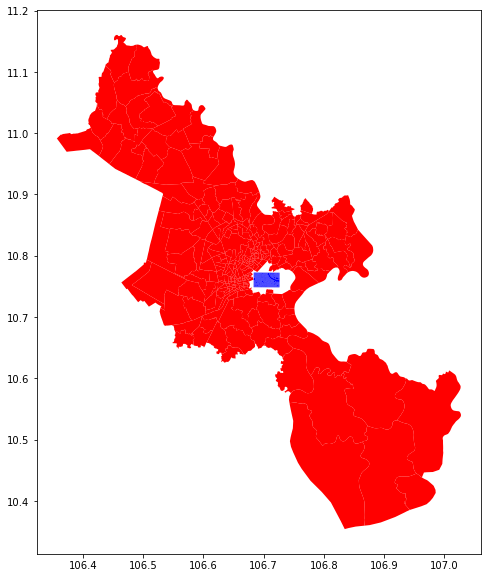

In [210]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
external_zones.plot(ax=ax, color='red')
lu.plot(ax=ax, color='blue')

In [211]:
search_radius=1200 # roughly 15 minutes walking

#### Define the accessibility metrics we are interested in, their min and max values and the column which is used for weighting the results.

In [212]:
prox_metrics={
    'Residential Access': {'column':'res_total','min': 0, 'max': 500000, 'from': 'emp_total'},
    'Employment Access': {'column':'emp_total','min': 0, 'max': 5000000, 'from': 'res_total'},
    'Education Access': {'column':'emp_naics_61','min': 0, 'max': 50000, 'from': 'res_total'},
    'Healthcare Access': {'column':'emp_naics_62','min': 0, 'max': 50000, 'from': 'res_total'}}

### First aggregate access to the external zones (from wards)

In [213]:
closest_node_ids_external = net.get_node_ids(x_col=external_zones['x_centroid'], y_col=external_zones['y_centroid'])

for name in prox_metrics:
    net.set(closest_node_ids_external, 
            variable=external_zones[prox_metrics[name]['column']], 
            name='{}_external'.format(name))

Removed 99 rows because they contain missing values
Removed 98 rows because they contain missing values
Removed 98 rows because they contain missing values
Removed 98 rows because they contain missing values


In [214]:
external_access={}
for name in prox_metrics:    
    external_access[name]=net.aggregate(distance=search_radius, type="sum", 
                        decay="linear", name='{}_external'.format(name),
                        imp_name='distance')

### Then aggregate access to the internal zones (from LU file)

In [215]:
closest_node_ids_internal = net.get_node_ids(x_col=lu['x_centroid'], y_col=lu['y_centroid'])

for name in prox_metrics:
    net.set(closest_node_ids_internal, 
            variable=lu[prox_metrics[name]['column']], 
            name='{}_internal'.format(name))

In [216]:
internal_access={}
for name in prox_metrics:    
    internal_access[name]=net.aggregate(distance=search_radius, type="sum", 
                        decay="linear", name='{}_internal'.format(name),
                        imp_name='distance')

### Add the access to external POIs to the acess to internal POIs to get the total access to each POI

In [217]:
overall_access={name: internal_access[name]+external_access[name] for name in internal_access}

#### Plot some of the results for illustration (Table area only)

In [218]:
internal_bbox=lu.total_bounds

In [219]:
table_node_ids=[ind for ind, n in nodes_df.iterrows() if (
    (n['lon']>internal_bbox[0]) and 
    (n['lon']<internal_bbox[2]) and 
    (n['lat']>internal_bbox[1]) and
    (n['lat']<internal_bbox[3]))]

In [220]:
def create_gdf_access(nodes_df, access_dict):
    nodes_gdf=gpd.GeoDataFrame(data=access_dict,geometry=gpd.points_from_xy(
        nodes_df['lon'], nodes_df['lat'], crs='EPSG:4326'))
    return nodes_gdf
    
def plot_gdf_access(gdf, to):
    fig, ax=plt.subplots(1, figsize=(12,10))
    gdf.plot(column=to, ax=ax, legend=True)

In [221]:
overall_access_table_only={x: overall_access[x][table_node_ids] for x in overall_access}

In [222]:
gdf_access=create_gdf_access(nodes_df.loc[table_node_ids],
                             overall_access_table_only)

Employment

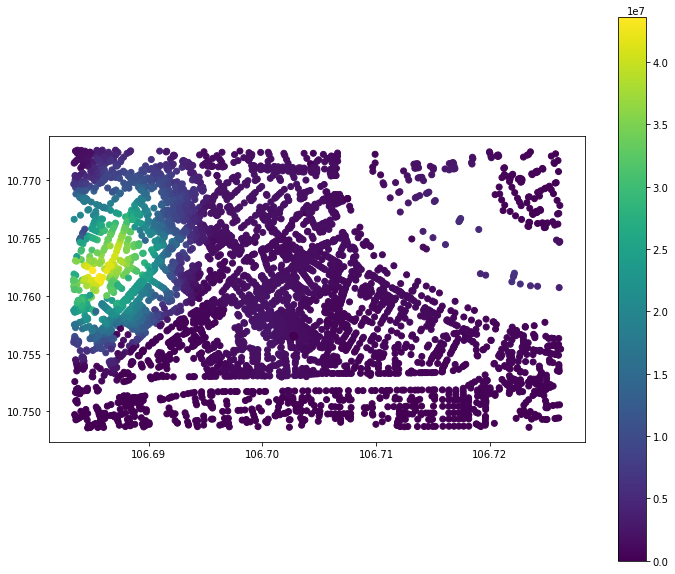

In [223]:
plot_gdf_access(gdf_access, 'Employment Access')

Residential

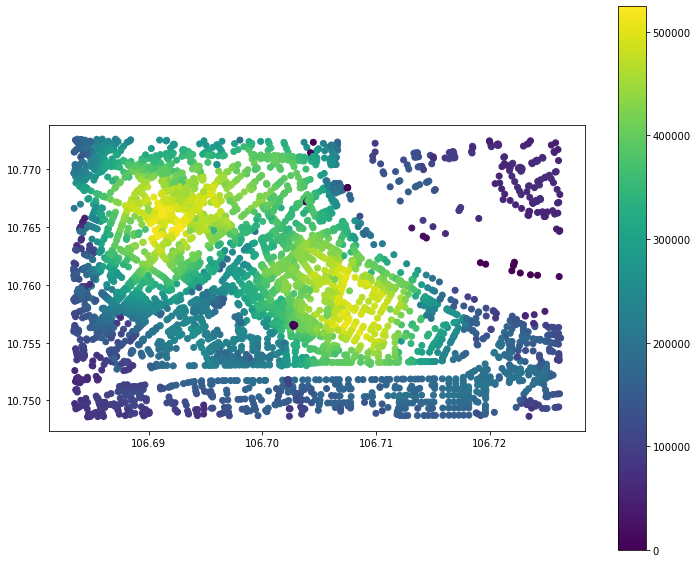

In [224]:
plot_gdf_access(gdf_access, 'Residential Access')

In [225]:
np.array([overall_access_table_only[x] for x in overall_access_table_only]).T.shape

(4905, 4)

Create some different output formats for the access heatmaps

In [226]:
access_table=np.column_stack([nodes_df.loc[table_node_ids, ['lat', 'lon']], 
                              np.array([overall_access_table_only[x] for x in overall_access_table_only]).T])

In [227]:
access_table=pd.DataFrame(overall_access_table_only)
access_table=access_table.merge(nodes_df, left_index=True, right_index=True)
access_table

,Residential Access,Employment Access,Education Access,Healthcare Access,lon,lat,id
id,,,,,,,
366367233,102735.971176,5.334380e+05,0.000000,0.000000,106.709701,10.771110,366367233
366367342,363166.643273,1.480024e+06,208751.518948,16913.701387,106.706294,10.764703,366367342
366368313,106081.159027,3.896139e+06,18440.676763,2707.331111,106.684155,10.754623,366368313
366369352,506614.147868,5.355328e+05,93860.627474,156.669107,106.707950,10.756230,366369352
366370535,221681.475680,6.703177e+05,96007.494230,0.000000,106.718253,10.756817,366370535
...,...,...,...,...,...,...,...
8708157088,516592.177322,2.292809e+07,406186.874729,32949.178271,106.690836,10.764242,8708157088
8815014772,58544.926369,4.382026e+05,134924.288746,0.000000,106.721482,10.770326,8815014772
8819566548,351160.035173,8.925926e+06,296362.126651,59471.538597,106.689412,10.770875,8819566548


##### Save a geojson which is compatible with the access layer of CityScope_JS

In [308]:
access_var_list=overall_access.keys()
access_cs_js_format=gdf_access.copy().__geo_interface__
access_cs_js_format['properties']=list(access_var_list)
del(access_cs_js_format['bbox'])
for i_f, feat in enumerate(access_cs_js_format['features']):
    access_cs_js_format['features'][i_f]['properties']=[normalise_indicator(
        feat['properties'][var], prox_metrics[var]['min'], prox_metrics[var]['max']) for var in access_var_list]
    del(access_cs_js_format['features'][i_f]['bbox'])

## Create a single access indicator for each POI

Compute a weighted average accross all nodes where each node is valued by the people coming to the POI from this node. For example, when computing accessibility to employment or amenities, we weight the accessibility at each node by how many people live at this node. For accessibility to residential, we weight by how many people work there. <br>
The 'from' variable for each access metric was already specified in the prox_metrics dictionary.<br>

A simple 'hack' to get the number of people employed/living at each node is to 'aggregate' with a search_radius of 1 meter. <br>

We can ignore the external zones for this

In [229]:
sources={}
all_source_columns=set([prox_metrics[name]['from'] for name in prox_metrics])
all_source_columns
for column in all_source_columns:
    net.set(closest_node_ids_internal, 
            variable=lu[column], 
            name='{}_source'.format(column))
    sources[column]=net.aggregate(distance=1, type="sum", 
                        decay="linear", name='{}_source'.format(column),
                        imp_name='distance')

In [230]:
weighted_access={}
for name in prox_metrics:
    from_var=prox_metrics[name]['from']
    total_from=sources[from_var].sum()
    if total_from==0:
        weighted_access[name]=0
    else:
        weighted_access[name]=(overall_access[name].multiply(sources[from_var])).sum()/total_from

In [231]:
weighted_access

{'Residential Access': 237575.62282002755,
 'Employment Access': 3819706.234734948,
 'Education Access': 139791.116547871,
 'Healthcare Access': 12711.460837782315}

In [232]:
for name in weighted_access:
    indicators.append({
        'raw_value': weighted_access[name],
        'value': normalise_indicator(weighted_access[name], prox_metrics[name]['min'], prox_metrics[name]['max']),
        'name': name,
        'type': 'radar'    
})

In [233]:
indicators

[{'raw_value': 0.42510504322763576,
  'value': 0.04251050432276358,
  'name': 'Res Density',
  'type': 'radar'},
 {'raw_value': 6.851801105033838,
  'value': 0.6851801105033838,
  'name': 'Emp Density',
  'type': 'radar'},
 {'raw_value': 0.062042817167492256,
  'value': 0.062042817167492256,
  'name': 'Live-Work Score',
  'type': 'radar'},
 {'raw_value': 1.0, 'value': 1.0, 'name': 'Res Diversity', 'type': 'radar'},
 {'raw_value': 0.5416405491664388,
  'value': 0.5416405491664388,
  'name': 'Emp Diversity',
  'type': 'radar'},
 {'raw_value': 237575.62282002755,
  'value': 0.4751512456400551,
  'name': 'Residential Access',
  'type': 'radar'},
 {'raw_value': 3819706.234734948,
  'value': 0.7639412469469895,
  'name': 'Employment Access',
  'type': 'radar'},
 {'raw_value': 139791.116547871,
  'value': 1,
  'name': 'Education Access',
  'type': 'radar'},
 {'raw_value': 12711.460837782315,
  'value': 0.2542292167556463,
  'name': 'Healthcare Access',
  'type': 'radar'}]

# Mobility Model

We will use the Simulation class from the CS_Spatial_Modules submodule

In [234]:
import sys
sys.path.insert(0,'../modules/CS_Spatial_Modules')
import Simulation

In [235]:
lu=lu.set_index('OBJECTID')

<AxesSubplot:>

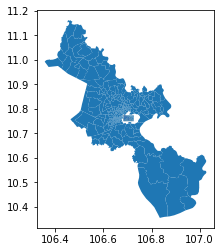

In [236]:
combined_zones=external_zones.append(lu).fillna(0)
combined_zones.plot()

### Create zone to zone distance matrix

In [237]:
combined_zones['node']=net.get_node_ids(
                x_col=combined_zones['x_centroid'],y_col=combined_zones['y_centroid'])   

Takes a few minutes:

In [238]:
zone_index=combined_zones.index
all_o_geoid=[]
for ind in zone_index:
    all_o_geoid.extend([ind]*len(zone_index))
all_d_geoid=list(zone_index)*len(zone_index)

all_o_nodes=combined_zones.loc[all_o_geoid,'node']
all_d_nodes=combined_zones.loc[all_d_geoid,'node']

all_dists=net.shortest_path_lengths(all_o_nodes,all_d_nodes, imp_name='distance')

In [239]:
all_dists_mat=np.reshape(all_dists, (len(zone_index), len(zone_index)))
dist_mat_df=pd.DataFrame(all_dists_mat)
dist_mat_df.columns=combined_zones.index
dist_mat_df.index=combined_zones.index

Replace zeros with a small distance to avid numerical issues

In [240]:
dist_mat_df=dist_mat_df.replace(0, 50)

In [241]:
dist_mat_df.head()

,26734,27121,27124,27154,27301,27334,27337,27340,27343,27370,...,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227
26734,50.000,633.115,1404.188,3242.666,4461.018,5714.932,5861.412,6248.188,6968.035,7667.652,...,4157.041,4253.884,4379.290,4867.567,4285.664,4922.439,4785.797,4786.404,4687.603,5039.415
27121,633.115,50.000,999.483,2837.961,4056.313,5310.227,5456.707,5843.483,6563.330,7262.947,...,3863.783,3963.032,4088.438,4574.309,3994.812,4629.181,4492.539,4493.146,4396.751,4748.563
27124,1404.188,999.483,50.000,1961.289,3179.641,4433.555,4580.035,4966.811,5686.658,6386.275,...,3710.929,3810.178,3935.584,4298.949,3841.958,4476.327,4297.217,4340.292,4243.897,4595.709
27154,3242.666,2837.961,1961.289,50.000,1315.974,2577.003,2859.282,3246.058,3965.905,4665.522,...,3830.036,3934.354,4061.456,4270.943,3967.830,4505.888,4269.211,4369.853,4369.769,4630.636
27301,4461.018,4056.313,3179.641,1315.974,50.000,1571.918,1913.618,2432.296,3260.771,3878.370,...,4017.350,4121.668,4248.770,4458.257,4155.144,4693.202,4456.525,4557.167,4557.083,4817.950


In [242]:
# dist_mat_df.to_csv('../outputs/dist_mat_s{}.csv'.format(s))

In [243]:
# dist_mat={}
# zone_index=combined_zones.index
# for o_ind in zone_index:
#     o_node=combined_zones.loc[o_ind]['node']
#     d_nodes=[combined_zones.loc[d_ind]['node'] for d_ind in zone_index]
#     dists=net.shortest_path_lengths([o_node]*len(d_nodes),d_nodes, imp_name='distance')
#     dists=[d if d>0 else 100 for d in dists ] # in case of same closest node
#     dist_mat[o_ind]={zone_index[d]: dists[d] for d in range(len(dists))}

In [244]:
# json.dump(dist_mat, open('../outputs/dist_mat_s{}'.format(s),'w'))
# dist_mat=json.load(open('../outputs/dist_mat_s{}'.format(s)))

### Create population based on land uses

In [245]:
import random
import numpy as np
import pandas as pd

def prob_floor(num):
    """
    Probabilistic "rounding" function
    eg. if num==1.2: this function will return 
    - 1.0 80% of the time 
    - 2.0 20% of the time
    """
    result=int(num)
    remainder=num-result
    if random.uniform(0, 1)<remainder:
        result+=1
    return result


def sample_home_locations(zones, work_geoid, dist_mat_df, n, beta=0.9):
    """ 
    Sample home locations using a simple gravity model.
    Attractiveness is proportional to the total residential capacity
    beta controls the distance decay
    """
    attraction=zones['res_total']
    impedance=[dist_mat_df.loc[hid,work_geoid] for hid in zones.index]
    weights=np.divide(attraction,np.power(impedance, beta))
    return np.random.choice(
        zones.index, replace=True, p=weights/sum(weights), size=n)

In [246]:
def create_simpop(zones, sample_fraction=0.01):
    simpop=[]
    for geoid, row in zones.iterrows():
        for naics_col in industry_columns:
            naics_code=naics_col.split('emp_naics_')[1]
            capacity=row[naics_col]*sample_fraction
            n_workers=prob_floor(capacity)
            home_locations=sample_home_locations(zones, geoid, dist_mat_df, n_workers, beta=0.9)
            # TODO: age and income sampling should be weighted according to NAICS
            # i.e. people working in retail have a different age and income distribution to professionals
            earnings=np.random.choice(['1', '2', '3', '4'], replace=True,size=n_workers)
            age=np.random.choice(range(20,70), replace=True,size=n_workers)
            for i_w in range(n_workers):
                simpop.append({'work_geoid': geoid,'home_geoid': home_locations[i_w],
                                                   'naics': naics_code, 'earnings': earnings[i_w],
                                                  'age': age[i_w]})
    return simpop

In [247]:
simpop=create_simpop(combined_zones, sample_fraction=0.0001)
simpop_df=pd.DataFrame(simpop)

#### Only include people who either live OR work in the SIMULATION (table) area

In [248]:
print(len(simpop_df))
simpop_df=simpop_df.loc[((simpop_df['home_geoid'].isin(lu.index))|
                         (simpop_df['work_geoid'].isin(lu.index)))]
print(len(simpop_df))

8457
8441


In [249]:
simpop_df=simpop_df.sample(500)

### Load the mode choice model

In [250]:
import pickle
import json
mc_model=pickle.load(open('../outputs/mode_choice_model.p', 'rb'))
model_description=json.load(open('../outputs/mc_model_features.json'))

class Logistic_Mode_Choice_model():
    def __init__(self, mc_model, model_description):
        self.options=model_description['mode_order']
        self.features=model_description['features']
        self.dummy_map=model_description['dummy_map']
        self.model=mc_model
    
    def predict_modes(self, all_trips_df):
        data=all_trips_df.copy()
        for attr in self.dummy_map:
            dummys=pd.get_dummies(data[attr], prefix=self.dummy_map[attr])
            for col in dummys.columns:
                data[col]=dummys[col]
        for feat in self.features:
            if not feat in data.columns:
                print('{} not in data'.format(feat))
                data[feat]=0
        X=data[self.features]
        y_pred_proba=self.model.predict_proba(X)
        # Do all probabilistic samples with single call random number generator
        y_pred_proba_cum=np.cumsum(y_pred_proba, axis=1)
        p_cut=np.random.uniform(0, 1, len(data))
        y_pred=[self.options[np.argmax(y_pred_proba_cum[i]>p_cut[i])] for i in range(len(data))]
#         y_pred=[self.options[np.random.choice(range(len(y_pred_proba[i])), size=1, replace=True, p=y_pred_proba[i]
#                                 )[0]] for i in range(len(y_pred_proba))]
        all_trips_df['mode']=y_pred
        return all_trips_df

/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Mode and profile descriptions

In [251]:
mode_colors=['#7fc97f',
'#beaed4',
'#fdc086',
'#ffff99',
'#386cb0',
'#f0027f',
'#bf5b17']

mode_descriptions=[{'name': model_description['mode_order'][i], 'color': mode_colors[i]
                  } for i in range(len(model_description['mode_order']))]

profile_descriptions = [{"name": '1',
                        'color': "#7fc97f"},
                         {"name": '2',
                        'color': "#beaed4"},
                         {"name": '3',
                        'color': "#fdc086"},
                        {"name": '4',
                        'color': "#ffff99"},
                        ]

### Create Mobility System

All modes use same network but with different average speeds

In [252]:
edges_df['travel_time_drive']=edges_df['distance']/(50000/3600) # 50km/hr
edges_df['travel_time_walk']=edges_df['distance']/(5000/3600) # 5km/hr
edges_df['travel_time_cycle']=edges_df['distance']/(12000/3600) # 12km/hr

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance", "travel_time_drive", "travel_time_walk", "travel_time_cycle"]])

In [253]:
networks={}
networks['drive']=Simulation.PdnaNetwork(net)

building link attribute lookup


In [254]:
mode_dicts={}
mode_dicts['Motorcycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Electric bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Walking']={'target_network_id': 'drive','travel_time_metric': 'travel_time_walk'}
mode_dicts['Bus']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Car']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Others']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}

In [255]:
modes={mode: Simulation.Mode(mode_dicts[mode]) for mode in mode_dicts}
mob_sys=Simulation.MobilitySystem(modes=modes, networks=networks)

In [256]:
sim=Simulation.Simulation(simpop_df, mob_sys, combined_zones, sim_geoids=lu.index,
            mode_descriptions=mode_descriptions, profile_descriptions=profile_descriptions)
sim.set_choice_models(mode_chooser=Logistic_Mode_Choice_model(mc_model, model_description))

Getting internal nodes
Finding closest nodes to every zone centroid


### Run the Simulation

In [257]:
simpop_df=sim.create_simple_HWOWH_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
all_trips_df['distance']=sim.mob_sys.networks['drive'].net.shortest_path_lengths(
    [n[0] for n in all_trips_df['from_possible_nodes_drive']],
    [n[0] for n in all_trips_df['to_possible_nodes_drive']],
    imp_name='distance')
all_trips_df=sim.mode_chooser.predict_modes(all_trips_df)
route_table=sim.get_routes_table(all_trips_df)
deckgl_trips=sim.routes_to_deckgl_trip(route_table)

emp_naics_11 not in data
emp_naics_21 not in data
emp_naics_23 not in data
emp_naics_48-49 not in data
emp_naics_72 not in data
emp_naics_81 not in data


../modules/CS_Spatial_Modules/Simulation.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['node_path']=routes['node_path']
../modules/CS_Spatial_Modules/Simulation.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['attributes']=routes['attributes']


#### Create additional outputs

In [258]:
route_gdf=sim.route_table_to_geo(route_table)
start_day_time_stamp=1626307200
trips_geo=sim.route_gdf_to_trips_geojson(route_gdf[['naics','earnings','age', 'mode', 'line_string', 'start_time', 'attributes', 'node_path']], 
                                         start_day_time_stamp=start_day_time_stamp)

#### Calculate a Mobility CO2 Indicator

Distances by mode (filtering out very large distances due to pandana failure to find route)

In [259]:
distances_by_mode=route_table.loc[route_table['distance']<1e6].groupby('mode')['distance'].sum()
distances_by_mode

mode
Bicycle              233037.835
Bus                  498493.353
Car                   17026.009
Electric bicycle       5056.694
Motorcycle          8202211.492
Others               469393.965
Walking              112382.016
Name: distance, dtype: float64

Values below are guesses- need to be replaced by estimates specific to Vietnam/HCMC

In [260]:
co2_kg_per_meter={'Motorcycle': 0.26/1000,
                 'Car': 0.27/1000,
                 'Electric bicycle': 0.1/1000,
                 'Bicycle': 0,
                 'Walking': 0,
                 'Bus': 0.2/1000,
                 'Others': 0.27/1000}

In [261]:
total_co2=sum([distances_by_mode[mode]*co2_kg_per_meter[mode] for mode in distances_by_mode.index])

In [262]:
co2_kg_per_person_day=total_co2/len(simpop_df)
co2_kg_per_person_day

4.7282254418

Normalise the indicator- note that the min and max are flipped because smaller is better

In [263]:
co2_max=6
co2_min=2

In [264]:
co2_ind_norm = normalise_indicator(co2_kg_per_person_day, min_value=co2_max, max_value=co2_min)

In [265]:
indicators.append({
        'raw_value': co2_kg_per_person_day,
        'value': co2_ind_norm,
        'name': 'Sustainable Mobility',
        'type': 'radar'    
})

# Save all the outputs for visualising on the CityScope

In [285]:
json.dump(trips_geo, open('./results/scenario_{}/abm.geojson'.format(s), 'w'))
json.dump(deckgl_trips, open('./results/scenario_{}/abm.json'.format(s), 'w'))
json.dump(indicators, open('./results/scenario_{}/indicators.json'.format(s), 'w'))
# lu.to_file('./results/scenario_{}/lu.geojson'.format(s), driver='GeoJSON')
gdf_access.to_file('./results/scenario_{}/gdf_access.geojson'.format(s), driver='GeoJSON')
access_table.to_csv('./results/scenario_{}/access_table.csv'.format(s))
json.dump(access_cs_js_format, open('./results/scenario_{}/access_cs_js_format.geojson'.format(s), 'w'))

In [267]:
# geogrid=lu[['geometry', 'CSLLandTyp', 'Storey']].__geo_interface__

In [268]:
# geogrid_data=[]
# for i_g, g in enumerate(geogrid['features']):
#     name=abbreviate_type_name(g['properties']['CSLLandTyp'])
#     color=types[name]['color']
#     geogrid_data.append({'color': color,
#                        'name': name,
#                        'height': g['properties']['Storey'],
#                        'id': i_g,
#                        'interactive': False})

In [269]:
# geogrid=s0_lu[['geometry']].__geo_interface__
# geogrid['properties']={'types': types,
#                       "geogrid_to_tui_mapping": {},
# "header": {
# "cellSize": 50,
# "latitude": 37.478126,
# "longitude": -122.136798,
# "ncols": 11,
# "nrows": 15,
# "projection": "+proj=lcc +lat_1=42.68333333333333 +lat_2=41.71666666666667 +lat_0=41 +lon_0=-71.5 +x_0=200000 +y_0=750000 +ellps=GRS80 +datum=NAD83 +units=m +no_def",
# "rotation": 30,
# "tableName": "hcmc_static"
# }}




In [270]:
# json.dump(geogrid, open('geogrid.geojson', 'w'))
# json.dump(geogrid_data, open('geogrid_data.json', 'w'))
# json.dump(deckgl_trips, open('trips.json', 'w'))

In [271]:
# import requests
# table_name='hcmc_static'
# post_url='https://cityio.media.mit.edu/api/table/'+table_name
# r = requests.post(post_url+'/ABM2', data = json.dumps(deckgl_trips),
#     headers={'Content-Type': 'application/json'})
# print('Post ABM: {}'.format(r))

# r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid),
#     headers={'Content-Type': 'application/json'})
# print('Post geogrid: {}'.format(r))

# r = requests.post(post_url+'/GEOGRIDDATA', data = json.dumps(geogrid_data),
#     headers={'Content-Type': 'application/json'})
# print('Post geogriddata: {}'.format(r))